In [6]:
from random import randint

for i in range(1,11):
    print(randint(1,10))

1
5
2
3
5
3
9
2
8
8


In [55]:
pc_ref = [0, 25, -60, 400, -20, -75, 0, 300, -62.5, 66.7, 0, 40, -42.9, -25, -66.7, 0, 0, 700, -12.5, -28.6]
pc_tst = [0, 400, -60, 400, -20, -75, 0, 0, 300, 0]

def get_chunks(lst):
    r=[]
    chunk_size = 3
    tot = len(lst)
    for idx, val in enumerate(lst):
        end_idx = idx+chunk_size
        if end_idx <= tot:
            r.append(lst[idx:end_idx])
    return r

ref_chunks = get_chunks(pc_ref)
tst_chunks = get_chunks(pc_tst)

In [79]:
pc_ref = [0.252, 0.3061, 0.2328, 1.4866, -0.0304, -0.2396, 0.2776, -0.559, 0.1776, -0.0879, -0.2489, 0.191, -0.1669, 0.2069, -0.0082, 0.0303, 0.1514, -0.5416, 0.1393, -0.279, 0.1289, 0.0536, 0.0173, 0.0729, -0.3921, 0.331, -0.0669, -0.8499, 0.3064, 0.1968, 0.0437, -0.2584, 0.0821, -0.1622, 0.0575, 0.4276, 0.1731, 0.1696, -0.0697, 0.2628, -0.161, 0.1347, -0.1344, 0.2343, 0.2603, -0.3267, 0.1155, -0.1771, 0.6486, 0.1485, -0.9008, 0.5201, 0.0352, 0.0058, 0.2433, -0.0338, -0.1182, -0.1072, -0.2131, 0.0788, -0.2011, -0.5752, 0.2088, 0.1272, 0.1737, 0.0688, 0.0179, 0.0266, -0.1226, -0.3593, -0.3145, 0.4753, -0.6577, -0.4921, 0.6385, -0.1851, 0.1173, 0.1288, -0.1917, 0.466, 0.1443, -0.1435, 0.1033, -0.033, 0.1452, -0.041, -0.1955, 0.2475, 0.1176, 0.1048, -0.1507, -0.0141, 0.0763, 0.0129, 0.1513, -0.0414, -0.9417, 0.562, 0.0129, -0.291, 0.3272, 0.497, 0.0291, 0.1116, 0.07, -0.1977, -0.096, 0.1428, -0.1951, -0.1208, 0.2339, -0.3064, 0.1438, 0.1687, -0.011, 0.2247, 0.2931, 0.0273, 0.3568, 0.1841, 0.0173, -0.2452, 0.3968, 0.2555, -0.2334, 0.0639, 0.0635, 0.0594, -0.1268, 0.1941, 0.1845, -0.3609, -0.1249, 0.227, -0.5049, 0.2084, 0.346, -0.1565, -0.1739, 0.1898, -0.2511, 0.162, 0.1262, 0.4644, 1.4146, 1.3239, -0.2552, 0.5043, 0.2696, 1.3639, 0.9492, -0.6752, -0.8053, 0.3686, 0.224, -0.0946, 0.3022, 0.9325, 0.0764, 1.1665, 0.8176, 0.8777, -0.2752, 0.3193, -0.0129, 0.2201, 0.5784, -0.7921, 0.5223, 0.0881, 0.7826, -0.1728, 0.215, 0.1403, -0.1354, -0.7929, -1.6224, -0.4311, -3.9419, 2.0467, 0.3975, -0.0158, 0.1819, -0.068, 1.6716, -0.1723, -0.0134, -0.816, 0.283, -0.1722, 0.8016, -0.1964, 0.3173, 0.6438, 0.1002, -0.1255, 0.6785, -0.0524, -0.0911, 0.1621, 0.4624, 0.1326, -0.2818, -0.4339, 0.1541]
pc_tst = [0.1776, -0.0879, -0.2489, 0.191, -0.1669, 0.2069, -0.0082, 0.0303, 0.1514, -0.5416]

def get_chunks(lst):
    r=[]
    chunk_size = 10
    tot = len(lst)
    for idx, val in enumerate(lst):
        end_idx = idx+chunk_size
        if end_idx <= tot:
            r.append(lst[idx:end_idx])
    return r

ref_chunks = get_chunks(pc_ref)
tst_chunks = get_chunks(pc_tst)

In [67]:
len(tst_chunks)

1

In [73]:
print(ref_chunks)
print(tst_chunks)

[[0.252, 0.3061, 0.2328, 1.4866, -0.0304, -0.2396, 0.2776, -0.559, 0.1776, -0.0879], [0.3061, 0.2328, 1.4866, -0.0304, -0.2396, 0.2776, -0.559, 0.1776, -0.0879, -0.2489], [0.2328, 1.4866, -0.0304, -0.2396, 0.2776, -0.559, 0.1776, -0.0879, -0.2489, 0.191], [1.4866, -0.0304, -0.2396, 0.2776, -0.559, 0.1776, -0.0879, -0.2489, 0.191, -0.1669], [-0.0304, -0.2396, 0.2776, -0.559, 0.1776, -0.0879, -0.2489, 0.191, -0.1669, 0.2069], [-0.2396, 0.2776, -0.559, 0.1776, -0.0879, -0.2489, 0.191, -0.1669, 0.2069, -0.0082], [0.2776, -0.559, 0.1776, -0.0879, -0.2489, 0.191, -0.1669, 0.2069, -0.0082, 0.0303], [-0.559, 0.1776, -0.0879, -0.2489, 0.191, -0.1669, 0.2069, -0.0082, 0.0303, 0.1514], [0.1776, -0.0879, -0.2489, 0.191, -0.1669, 0.2069, -0.0082, 0.0303, 0.1514, -0.5416], [-0.0879, -0.2489, 0.191, -0.1669, 0.2069, -0.0082, 0.0303, 0.1514, -0.5416, 0.1393], [-0.2489, 0.191, -0.1669, 0.2069, -0.0082, 0.0303, 0.1514, -0.5416, 0.1393, -0.279], [0.191, -0.1669, 0.2069, -0.0082, 0.0303, 0.1514, -0.5416, 

In [80]:
def chunk_diff(ref_lst, tst_lst):
    cntr = 0
    chunk_size = len(tst_lst[0])
    sm_lst = []
    sm_idx_dic = {}
    print(chunk_size)
    for i in tst_lst:
        for j in ref_lst:
            diff = []
            for k in range(chunk_size):
                diff.append(abs(i[k] - j[k]))
            cntr += 1
            sm = sum(diff)
            # sm_lst.append({'k': f'{cntr}: {i} vs {j}', 'sm': sm})
            sm_lst.append({'k': cntr, 'sm': sm})
    return sm_lst

sm_lst = chunk_diff(ref_chunks, tst_chunks)

10


In [82]:
from typing import List, Dict

def sort_dicts_by_value(dicts: List[Dict], key: str) -> List[Dict]:
    """
    Sorts a list of dictionaries by the specified key value.

    :param dicts: List of dictionaries to be sorted
    :param key: The key by which the dictionaries should be sorted
    :return: A list of dictionaries sorted by the specified key
    """
    try:
        return sorted(dicts, key=lambda x: x[key])
    except KeyError:
        raise KeyError(f"One or more dictionaries do not have the key '{key}'")
    except TypeError:
        raise TypeError(f"The value for key '{key}' is not comparable")

sorted_list = sort_dicts_by_value(sm_lst, 'sm')
print(sorted_list[0],sorted_list[-1])


{'k': 9, 'sm': 0.0} {'k': 176, 'sm': 11.8161}


In [61]:

from binance.client import Client
from binance.enums import *
from time import time
import pickle as pickle
from datetime import datetime
import pandas as pd
from pathlib import Path
from datetime import datetime
import json


downloads_path = str(Path.home() / "Downloads")
documents_path = str(Path.home() / "Documents")
tst_fn = f'{downloads_path}\\hd.csv'
hd_dl_fn = f'{downloads_path}\\hd_dl.csv'
qualifying_trades_fn = f'{downloads_path}\\qualifying_trades.csv'


def get_client():
    fn = f'{documents_path}\\key\\binance-key.pickle'
    with open(fn, 'rb') as handle:
        k = pickle.load(handle)
    return Client(k['API_KEY'], k['API_SECRET'])

def get_config(file_path):
    with open(file_path, 'r') as file:
        config = json.load(file)
    return config


def get_chunks(lst, chunk_size):
    r=[]
    tot = len(lst)
    for idx, val in enumerate(lst):
        end_idx = idx+chunk_size
        if end_idx <= tot:
            r.append(lst[idx:end_idx])
    return r

def get_pc(hd_df):
    close_price = list(hd_df['close'])
    ts = list(hd_df['time'])
    pc = []
    for idx, val in enumerate(close_price):
        if idx==0:
            pc.append({'time': ts[0], 'pc': 0})
        else:
            previous_price = close_price[idx-1]
            current_price = val
            pc_val = (round((current_price*100/previous_price)-100, 4))
            pc.append({'time': ts[idx], 'pc': pc_val})
    pc_df = pd.DataFrame(pc)
    return pc_df

def get_trades(hd_df, chunk_size):
    close_price = list(hd_df['close'])
    high_price = list(hd_df['high'])
    low_price = list(hd_df['low'])
    longs=[]
    shorts=[]
    long_qualified = []
    short_qualified = []
    tot = len(close_price)
    for idx in range(len(close_price)):
        if (idx + chunk_size) <= tot:
            cp = close_price[idx]
            max_price = max(high_price[idx:idx + chunk_size])
            min_price = min(low_price[idx:idx + chunk_size])
            long_roi = round((max_price*100/cp)-100, 4)
            short_roi = round((cp*100/min_price)-100, 4)
            longs.append({'long': long_roi})
            long_qualified.append(long_roi >= roi_threshold)
            shorts.append({'short': short_roi})
            short_qualified.append(short_roi >= roi_threshold)
        else:
            long_roi = 0.0
            short_roi = 0.0
            longs.append({'long': long_roi})
            long_qualified.append(False)
            shorts.append({'short': short_roi})
            short_qualified.append(False)
    long_trades_df = pd.DataFrame(longs)
    short_trades_df = pd.DataFrame(shorts)
    long_qualified_df = pd.DataFrame(long_qualified)
    short_qualified_df = pd.DataFrame(short_qualified)
    return long_trades_df, short_trades_df, long_qualified, short_qualified

def download_hd(start_timestamp, end_timestamp, candlestick): 
    client = get_client()
    data = []
    tot = (end_timestamp - start_timestamp)/(900*500)
    cntr = 0
    for current_sts in range(start_timestamp, end_timestamp+1, 900*500):
        next_ets = current_sts + 900*500 if (current_sts + 900*500) < end_timestamp else end_timestamp
        print(current_sts, next_ets, f'100% completed') if next_ets == end_timestamp else print(current_sts, next_ets, f'{round(cntr*100/tot, 1)}% completed')
        cntr += 1
        
        klines = client.futures_historical_klines('BTCUSDT', candlestick, current_sts*1000, next_ets*1000, limit=500)
        
        for kline in klines:
            timestamp = kline[0]/1000
            open_price = float(kline[1])
            high_price = float(kline[2])
            low_price = float(kline[3])
            close_price = float(kline[4])
            volume = float(kline[5])

            data.append([timestamp, open_price, high_price, low_price, close_price, volume])

    df = pd.DataFrame(data, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
    df.to_csv(hd_dl_fn, index=False)
    print('Historical Data Exported!\t', hd_dl_fn)
    return df

def read_local_hd(fn):
    return pd.read_csv(fn)

def get_qualifying_trades(df):
    close_pc_df = get_pc(df)
    long_trades_df, short_trades_df, long_qualified, short_qualified = get_trades(df, chunk_size)
    df['close_pc'] = close_pc_df['pc']
    df['long'] = long_trades_df
    df['short'] = short_trades_df
    df['long_qualified'] = long_qualified
    df['short_qualified'] = short_qualified
    df.to_csv(qualifying_trades_fn, index=False)
    print('Qualifying Trades Data Exported!', qualifying_trades_fn)
    return df

def get_chunks(qt_df):
    lst = list(qt_df['close_pc'])
    r=[]
    tot = len(lst)
    for idx, val in enumerate(lst):
        if idx < chunk_size:
            r.append([0]*chunk_size)
        else:
            r.append(lst[idx-chunk_size:idx])
    qt_df['ref_chunks'] = r
    qt_df.to_csv(f'{downloads_path}/ref_chunks.csv', index=False)
    print('Ref Chunks Exported!', f'{downloads_path}/ref_chunks.csv')
    return qt_df

def get_tst_chunks(ref_chunks_df):
    long_qualified = list(ref_chunks_df['long_qualified'])
    short_qualified = list(ref_chunks_df['short_qualified'])
    ref_chunks_lst = list(ref_chunks_df['ref_chunks'])
    r=[]
    tst_lst = []
    chunk_diff_lst = []
    tst_lst_samp = [0.0058, 0.2433, -0.0338, -0.1182, -0.1072, -0.2131, 0.0788, -0.2011, -0.5752, 0.2088]
    for idx in range(len(long_qualified)):
        if (idx < chunk_size) or ((long_qualified[idx] == False) and (short_qualified[idx] == False)) :
            r.append(None)
            chunk_diff_lst.append(None)
        else:
            if (long_qualified[idx] == True) or (short_qualified[idx] == True):
                r.append(ref_chunks_lst[idx])
                tst_lst.append(ref_chunks_lst[idx])

    ref_chunks_df['tst_chunks'] = r
    ref_chunks_df['sm'] = chunk_diff_lst
    ref_chunks_df.to_csv(f'{downloads_path}/tst_chunks.csv', index=False)
    print('TST Chunks Exported!', f'{downloads_path}/tst_chunks.csv')
    return ref_chunks_df, tst_lst

config = get_config('config.json')
candlestick = config['candlestick']
chunk_size = config['chunk_size']
roi_threshold = config['roi_threshold']
sm_threshold = config['sm_threshold']

start_timestamp = 1609459200 #  January 1, 2021 12:00:00 AM
end_timestamp = 1719721304

# ref_chunks = get_chunks(pc_ref)
# tst_chunks = get_chunks(pc_tst)
# hd = read_local_hd(hd_dl_fn)
# qt_df = get_qualifying_trades(hd)

# ref_chunks_df = get_chunks(qt_df)
# tst_chunks_df, tst_lst = get_tst_chunks(ref_chunks_df)

tst_chunks_df = pd.read_csv(f'{downloads_path}/tst_chunks.csv')
close_price_lst = list(tst_chunks_df['close'])
high_price_lst = list(tst_chunks_df['high'])
ref_chunks_lst_str = list(tst_chunks_df['ref_chunks'])
tst_chunks_lst_str = list(tst_chunks_df['tst_chunks'])
long_qualified_lst = list(tst_chunks_df['long_qualified'])
ts = list(tst_chunks_df['time'])


In [14]:
for idx in range(len(long_qualified_lst)):
    if long_qualified_lst[idx] and tst_chunks_lst[idx] != None:
        print(idx, tst_chunks_lst[idx])
        print(type(tst_chunks_lst[idx]))
        break
    break


0 nan
<class 'float'>


In [53]:
import math
import ast

from typing import List, Dict

def sort_dicts_by_value(dicts: List[Dict], key: str) -> List[Dict]:
    """
    Sorts a list of dictionaries by the specified key value.

    :param dicts: List of dictionaries to be sorted
    :param key: The key by which the dictionaries should be sorted
    :return: A list of dictionaries sorted by the specified key
    """
    try:
        return sorted(dicts, key=lambda x: x[key])
    except KeyError:
        raise KeyError(f"One or more dictionaries do not have the key '{key}'")
    except TypeError:
        raise TypeError(f"The value for key '{key}' is not comparable")

def all_zeros(lst):
    return all(x == 0 for x in lst)

# math.isnan(tst_chunks_lst[110])
def chunk_diff(ref_lst, tst_lst):
    cntr = 0
    chunk_size = len(tst_lst[0])
    sm_lst = []
    sm_idx_dic = {}
    for i in tst_lst:
        for j in ref_lst:
            diff = []
            if(all_zeros(j)) or (all_zeros(i)):
                continue
            else:
                for k in range(chunk_size):
                    diff.append(abs(i[k] - j[k]))
                cntr += 1
                sm = sum(diff)
                # sm_lst.append({'k': f'{cntr}: {i} vs {j}', 'sm': sm})
                sm_lst.append({'k': cntr, 'tst': i, 'ref': j, 'sm': sm})
    return sm_lst

def str_to_lst(val):
    try:
        return ast.literal_eval(val)
    except ValueError as e:
        return math.isnan(val)

# for idx in range(len(long_qualified_lst)):

tst_val_lst = [str_to_lst(tst_chunks_lst_str[29])]
ref_chunks_lst = [str_to_lst(i) for i in ref_chunks_lst_str]
chunk_diff_lst = chunk_diff(ref_chunks_lst, tst_val_lst)
sdbv = sort_dicts_by_value(chunk_diff_lst, 'sm')

In [42]:
for i in range(10):
    print(sdbv[i])

{'k': 20, 'tst': [0.1393, -0.279, 0.1289, 0.0536, 0.0173, 0.0729, -0.3921, 0.331, -0.0669, -0.8499], 'ref': [0.1393, -0.279, 0.1289, 0.0536, 0.0173, 0.0729, -0.3921, 0.331, -0.0669, -0.8499], 'sm': 0.0}
{'k': 118703, 'tst': [0.1393, -0.279, 0.1289, 0.0536, 0.0173, 0.0729, -0.3921, 0.331, -0.0669, -0.8499], 'ref': [0.1339, -0.2712, 0.1238, 0.11, -0.0212, 0.1032, -0.4732, -0.1148, 0.278, -0.763], 'sm': 1.1022}
{'k': 32325, 'tst': [0.1393, -0.279, 0.1289, 0.0536, 0.0173, 0.0729, -0.3921, 0.331, -0.0669, -0.8499], 'ref': [-0.2349, -0.0012, 0.107, 0.0887, -0.0334, 0.087, -0.3967, 0.1344, -0.1688, -0.8242], 'sm': 1.1025999999999998}
{'k': 81933, 'tst': [0.1393, -0.279, 0.1289, 0.0536, 0.0173, 0.0729, -0.3921, 0.331, -0.0669, -0.8499], 'ref': [0.0698, -0.2854, -0.074, -0.0168, -0.0024, 0.1081, -0.438, -0.0103, 0.042, -0.6446], 'sm': 1.1055}
{'k': 51881, 'tst': [0.1393, -0.279, 0.1289, 0.0536, 0.0173, 0.0729, -0.3921, 0.331, -0.0669, -0.8499], 'ref': [0.2045, -0.2967, 0.0766, 0.0257, 0.133, -0

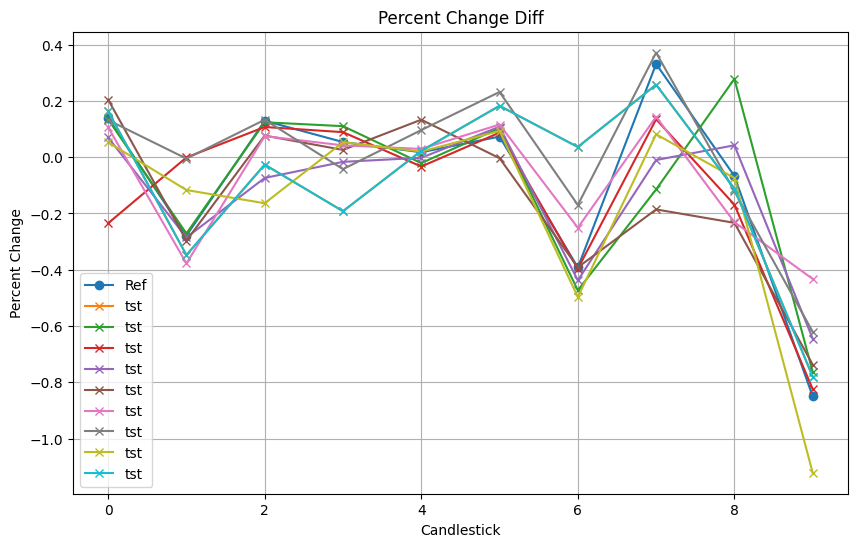

In [48]:
import matplotlib.pyplot as plt

def plot_lists(tst_lsts, ref_lst, tst_lst, label1='List 1', label2='List 2', title='Line Graph', xlabel='X-axis', ylabel='Y-axis'):
    plt.figure(figsize=(10, 6))
    plt.plot(ref_lst, label=label1, marker='o')
    plt.plot(tst_lst, label=label2, marker='x')
    for i in tst_lsts:
        plt.plot(i, label=label2, marker='x')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
ref_lst = [0.1393, -0.279, 0.1289, 0.0536, 0.0173, 0.0729, -0.3921, 0.331, -0.0669, -0.8499]
tst_lst = [0.1627, -0.3479, -0.0267, -0.1921, 0.0222, 0.1822, 0.036, 0.2573, -0.1122, -0.7797]
tst_lsts = [[0.1339, -0.2712, 0.1238, 0.11, -0.0212, 0.1032, -0.4732, -0.1148, 0.278, -0.763], [-0.2349, -0.0012, 0.107, 0.0887, -0.0334, 0.087, -0.3967, 0.1344, -0.1688, -0.8242], [0.0698, -0.2854, -0.074, -0.0168, -0.0024, 0.1081, -0.438, -0.0103, 0.042, -0.6446], [0.2045, -0.2967, 0.0766, 0.0257, 0.133, -0.0037, -0.3916, -0.1858, -0.2335, -0.7369], [0.1061, -0.3776, 0.0746, 0.0418, 0.0291, 0.1158, -0.2508, 0.1434, -0.231, -0.4328], [0.1317, -0.0052, 0.1327, -0.0427, 0.0961, 0.2314, -0.1699, 0.3709, -0.1205, -0.6201], [0.0528, -0.1169, -0.1639, 0.0529, 0.0199, 0.093, -0.4968, 0.0811, -0.0742, -1.1212], [0.1627, -0.3479, -0.0267, -0.1921, 0.0222, 0.1822, 0.036, 0.2573, -0.1122, -0.7797]]
plot_lists(tst_lsts, ref_lst, tst_lst, label1='Ref', label2='tst', title='Percent Change Diff', xlabel='Candlestick', ylabel='Percent Change')


In [63]:
for i in tst_lsts:
    idx = ref_chunks_lst.index(i)
    ep = close_price_lst[idx]
    hp = max(high_price_lst[idx:idx+chunk_size])
    roi = round((hp*100/ep)-100,2)
    print('idx', idx, 'ep', ep, 'max', hp, 'roi', roi)

idx 118712 ep 70806.0 max 70965.8 roi 0.23
idx 32334 ep 54164.95 max 54477.09 roi 0.58
idx 81942 ep 28699.9 max 28933.6 roi 0.81
idx 51890 ep 21154.7 max 21237.0 roi 0.39
idx 60759 ep 18736.0 max 18900.0 roi 0.88
idx 84579 ep 27059.8 max 27155.7 roi 0.35
idx 72901 ep 23298.0 max 23364.0 roi 0.28
idx 48441 ep 29930.3 max 30194.8 roi 0.88


In [64]:
sum([0.23, 0.58, 0.81, 0.39, 0.88, 0.35, 0.28, 0.88])/len([0.23, 0.58, 0.81, 0.39, 0.88, 0.35, 0.28, 0.88])

0.55